# DCGAN faces - 128x128

Import libraries

In [1]:
import os
import time
import datetime
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from __future__ import print_function
from PIL import Image

%matplotlib inline

Set up paths

In [2]:
dataset_dir = './dataset/celeba-128/'
figures_dir = './figures/celeba-128/'
checkpoints_dir = './checkpoints/celeba-128/'
graphs_dir = './graphs/celeba-128'

Set up hyperparameters

In [3]:
workers = 2

batch_size = 128
image_size = 128

nc = 3
noise_dim = 100

nfg = 64
nfd = 64

epochs = 50

g_learning_rate = 0.0002
d_learning_rate = 0.000035
beta1 = 0.5
beta2 = 0.999

True if you want to load the model from disk, False if you want the model to be initialized from scratch

In [4]:
load_model = False

Set up GPU device for training

In [5]:
device = torch.device('cuda:0')

Load the dataset

In [6]:
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(dataset_dir, transform=transform)
data_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=workers)

View samples from the dataset

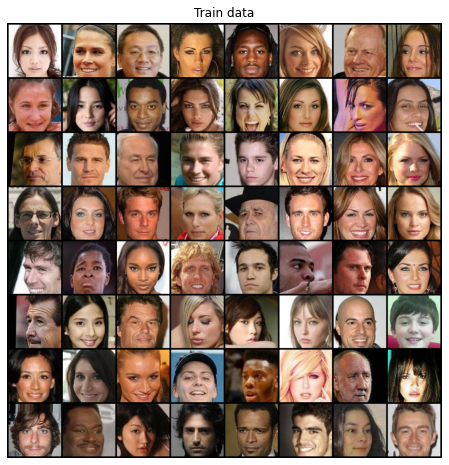

In [7]:
ds_sample = next(iter(data_loader))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Train data')
grid = np.transpose(utils.make_grid(ds_sample[0].to(device)[:64], padding=4, normalize=True).cpu(), (1, 2, 0))
plt.imshow(grid)

Define a method for weights initialization

In [8]:
def init_weights(model):
    if model.__class__.__name__.find('Conv') != -1:
        nn.init.normal_(model.weight, 0.0, 0.02)
    elif model.__class__.__name__.find('BatchNorm') != -1:
        nn.init.normal_(model.weight, 1.0, 0.02)
        nn.init.zeros_(model.bias)

Define the generator network

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, nfg*16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(nfg*16),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(nfg*16, nfg*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nfg*8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(nfg*8, nfg*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nfg*4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(nfg*4, nfg*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nfg*2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(nfg*2, nfg, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nfg),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(nfg, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.model(input)

Define the discriminator network

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(nc, nfd, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Dropout2d(0.5, inplace=False),
            
            nn.Conv2d(nfd, nfd*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nfg*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nfd*2, nfd*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nfg*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nfd*4, nfd*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nfg*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nfd*8, nfd*16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nfg*16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Dropout2d(0.5, inplace=False),
            
            nn.Conv2d(nfd*16, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

Instantiate the generator and initialize its weights (option 1)

In [12]:
if load_model == False:
    generator = Generator().to(device)
    generator.apply(init_weights)

Instantiate the discriminator and initialize its weights (option 1)

In [13]:
if load_model == False:
    discriminator = Discriminator().to(device)
    discriminator.apply(init_weights)

Load the model from the disk (option 2)

In [14]:
if load_model == True:
    generator = torch.load(os.path.join(checkpoints_dir, 'generator.pt'))
    discriminator = torch.load(os.path.join(checkpoints_dir, 'discriminator.pt'))

Define the loss function (BinaryCrossEntropy)

In [15]:
cross_entropy = nn.BCELoss()

Define a noise vector to use to track progress

In [16]:
sample_noise = torch.randn(64, noise_dim, 1, 1, device=device)

Define the optimizers (Adam)

In [17]:
disc_optimizer = optim.Adam(discriminator.parameters(), lr=d_learning_rate, betas=(beta1, beta2))
gen_optimizer = optim.Adam(generator.parameters(), lr=g_learning_rate, betas=(beta1, beta2))

Define a function to plot loss

In [18]:
def plot_loss(gen_losses, disc_losses, epoch=None, save=False, show=True):
    plt.figure(figsize=(10, 5))
    plt.title('Generator and Discriminator losses')
    plt.plot(gen_losses, label='G')
    plt.plot(disc_losses, label='D')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    
    if save == True:
        plt.savefig(os.path.join(graphs_dir, f'loss_{epoch}.jpg'))
    if show == True:
        plt.show()

Train both networks simultaneously

[1/50][1/1583] 	D-Loss:2.4987	 G-Loss:1.6613	 D(x):0.3902	 D(G(z)):0.4066	 G(z):0.3764
[1/50][101/1583] 	D-Loss:3.5380	 G-Loss:3.6602	 D(x):0.4801	 D(G(z)):0.5801	 G(z):0.1310
[1/50][201/1583] 	D-Loss:3.0290	 G-Loss:3.1373	 D(x):0.3784	 D(G(z)):0.3798	 G(z):0.1700
[1/50][301/1583] 	D-Loss:1.9633	 G-Loss:1.5592	 D(x):0.4675	 D(G(z)):0.4183	 G(z):0.3402
[1/50][401/1583] 	D-Loss:1.9981	 G-Loss:1.1809	 D(x):0.4910	 D(G(z)):0.4913	 G(z):0.4588
[1/50][501/1583] 	D-Loss:1.8014	 G-Loss:0.9103	 D(x):0.5354	 D(G(z)):0.4813	 G(z):0.4855
[1/50][601/1583] 	D-Loss:1.8653	 G-Loss:0.9791	 D(x):0.5183	 D(G(z)):0.5321	 G(z):0.4724
[1/50][701/1583] 	D-Loss:1.7681	 G-Loss:0.9619	 D(x):0.4366	 D(G(z)):0.4305	 G(z):0.4654
[1/50][801/1583] 	D-Loss:1.5146	 G-Loss:1.1359	 D(x):0.5563	 D(G(z)):0.4624	 G(z):0.4347
[1/50][901/1583] 	D-Loss:1.5133	 G-Loss:1.4215	 D(x):0.5504	 D(G(z)):0.4723	 G(z):0.3412
[1/50][1001/1583] 	D-Loss:1.8625	 G-Loss:0.9515	 D(x):0.4966	 D(G(z)):0.5079	 G(z):0.4469
[1/50][1101/1583] 	D-L

[6/50][1001/1583] 	D-Loss:1.4665	 G-Loss:0.7780	 D(x):0.4836	 D(G(z)):0.5002	 G(z):0.4653
[6/50][1101/1583] 	D-Loss:1.4093	 G-Loss:0.7469	 D(x):0.4743	 D(G(z)):0.4671	 G(z):0.4839
[6/50][1201/1583] 	D-Loss:1.4832	 G-Loss:0.7645	 D(x):0.4806	 D(G(z)):0.5116	 G(z):0.4805
[6/50][1301/1583] 	D-Loss:1.4187	 G-Loss:0.7877	 D(x):0.4780	 D(G(z)):0.4766	 G(z):0.4645
[6/50][1401/1583] 	D-Loss:1.4339	 G-Loss:0.7489	 D(x):0.5157	 D(G(z)):0.5195	 G(z):0.4794
[6/50][1501/1583] 	D-Loss:1.3726	 G-Loss:0.7075	 D(x):0.5130	 D(G(z)):0.4930	 G(z):0.4984
Time elapsed for epoch 6: 0:45:10

[7/50][1/1583] 	D-Loss:1.4561	 G-Loss:0.7046	 D(x):0.4886	 D(G(z)):0.5084	 G(z):0.5011
[7/50][101/1583] 	D-Loss:1.3727	 G-Loss:0.7770	 D(x):0.5149	 D(G(z)):0.4905	 G(z):0.4696
[7/50][201/1583] 	D-Loss:1.5032	 G-Loss:0.7153	 D(x):0.4694	 D(G(z)):0.5069	 G(z):0.4992
[7/50][301/1583] 	D-Loss:1.4473	 G-Loss:0.7910	 D(x):0.4866	 D(G(z)):0.5005	 G(z):0.4616
[7/50][401/1583] 	D-Loss:1.4481	 G-Loss:0.7470	 D(x):0.4936	 D(G(z)):0.

[12/50][401/1583] 	D-Loss:1.4097	 G-Loss:0.7218	 D(x):0.4900	 D(G(z)):0.4947	 G(z):0.4915
[12/50][501/1583] 	D-Loss:1.4199	 G-Loss:0.6880	 D(x):0.5124	 D(G(z)):0.5202	 G(z):0.5052
[12/50][601/1583] 	D-Loss:1.4114	 G-Loss:0.7475	 D(x):0.4937	 D(G(z)):0.5004	 G(z):0.4782
[12/50][701/1583] 	D-Loss:1.3898	 G-Loss:0.7805	 D(x):0.4984	 D(G(z)):0.4891	 G(z):0.4633
[12/50][801/1583] 	D-Loss:1.4046	 G-Loss:0.6634	 D(x):0.4980	 D(G(z)):0.5001	 G(z):0.5184
[12/50][901/1583] 	D-Loss:1.3907	 G-Loss:0.7162	 D(x):0.5283	 D(G(z)):0.5123	 G(z):0.4917
[12/50][1001/1583] 	D-Loss:1.3776	 G-Loss:0.7091	 D(x):0.5000	 D(G(z)):0.4910	 G(z):0.4981
[12/50][1101/1583] 	D-Loss:1.4139	 G-Loss:0.7334	 D(x):0.5127	 D(G(z)):0.5142	 G(z):0.4841
[12/50][1201/1583] 	D-Loss:1.4502	 G-Loss:0.7319	 D(x):0.5071	 D(G(z)):0.5252	 G(z):0.4844
[12/50][1301/1583] 	D-Loss:1.4226	 G-Loss:0.7372	 D(x):0.5077	 D(G(z)):0.5186	 G(z):0.4824
[12/50][1401/1583] 	D-Loss:1.3842	 G-Loss:0.7222	 D(x):0.5007	 D(G(z)):0.4906	 G(z):0.4902
[12/5

[17/50][1301/1583] 	D-Loss:1.3502	 G-Loss:0.7375	 D(x):0.5138	 D(G(z)):0.4898	 G(z):0.4812
[17/50][1401/1583] 	D-Loss:1.4543	 G-Loss:0.6822	 D(x):0.4737	 D(G(z)):0.4990	 G(z):0.5083
[17/50][1501/1583] 	D-Loss:1.4088	 G-Loss:0.7094	 D(x):0.5013	 D(G(z)):0.5047	 G(z):0.4966
Time elapsed for epoch 17: 0:44:41

[18/50][1/1583] 	D-Loss:1.3049	 G-Loss:0.7095	 D(x):0.5362	 D(G(z)):0.4883	 G(z):0.4947
[18/50][101/1583] 	D-Loss:1.4386	 G-Loss:0.7316	 D(x):0.4768	 D(G(z)):0.4959	 G(z):0.4856
[18/50][201/1583] 	D-Loss:1.3915	 G-Loss:0.7604	 D(x):0.4899	 D(G(z)):0.4810	 G(z):0.4717
[18/50][301/1583] 	D-Loss:1.3957	 G-Loss:0.7179	 D(x):0.4961	 D(G(z)):0.4936	 G(z):0.4905
[18/50][401/1583] 	D-Loss:1.4050	 G-Loss:0.7687	 D(x):0.4874	 D(G(z)):0.4865	 G(z):0.4660
[18/50][501/1583] 	D-Loss:1.3712	 G-Loss:0.7319	 D(x):0.5054	 D(G(z)):0.4896	 G(z):0.4848
[18/50][601/1583] 	D-Loss:1.3942	 G-Loss:0.7121	 D(x):0.5016	 D(G(z)):0.5010	 G(z):0.4967
[18/50][701/1583] 	D-Loss:1.3804	 G-Loss:0.7235	 D(x):0.5002	 D

[23/50][601/1583] 	D-Loss:1.3471	 G-Loss:0.6730	 D(x):0.5153	 D(G(z)):0.4890	 G(z):0.5130
[23/50][701/1583] 	D-Loss:1.3735	 G-Loss:0.7499	 D(x):0.5101	 D(G(z)):0.4972	 G(z):0.4750
[23/50][801/1583] 	D-Loss:1.4341	 G-Loss:0.7492	 D(x):0.4952	 D(G(z)):0.5117	 G(z):0.4775
[23/50][901/1583] 	D-Loss:1.4128	 G-Loss:0.7049	 D(x):0.4692	 D(G(z)):0.4713	 G(z):0.4965
[23/50][1001/1583] 	D-Loss:1.3703	 G-Loss:0.7736	 D(x):0.4717	 D(G(z)):0.4549	 G(z):0.4670
[23/50][1101/1583] 	D-Loss:1.3978	 G-Loss:0.7378	 D(x):0.5249	 D(G(z)):0.5221	 G(z):0.4812
[23/50][1201/1583] 	D-Loss:1.4149	 G-Loss:0.6519	 D(x):0.5082	 D(G(z)):0.5139	 G(z):0.5264
[23/50][1301/1583] 	D-Loss:1.4183	 G-Loss:0.6833	 D(x):0.5123	 D(G(z)):0.5206	 G(z):0.5084
[23/50][1401/1583] 	D-Loss:1.3501	 G-Loss:0.6711	 D(x):0.5022	 D(G(z)):0.4783	 G(z):0.5157
[23/50][1501/1583] 	D-Loss:1.3678	 G-Loss:0.7904	 D(x):0.5210	 D(G(z)):0.5041	 G(z):0.4579
Time elapsed for epoch 23: 0:44:22

[24/50][1/1583] 	D-Loss:1.4469	 G-Loss:0.7165	 D(x):0.4970

[28/50][1501/1583] 	D-Loss:1.5778	 G-Loss:0.9015	 D(x):0.4972	 D(G(z)):0.5747	 G(z):0.4128
Time elapsed for epoch 28: 0:44:52

[29/50][1/1583] 	D-Loss:1.4336	 G-Loss:0.7373	 D(x):0.4623	 D(G(z)):0.4693	 G(z):0.4851
[29/50][101/1583] 	D-Loss:1.2845	 G-Loss:0.7198	 D(x):0.5210	 D(G(z)):0.4567	 G(z):0.4926
[29/50][201/1583] 	D-Loss:1.5389	 G-Loss:0.8589	 D(x):0.5940	 D(G(z)):0.6256	 G(z):0.4313
[29/50][301/1583] 	D-Loss:1.2921	 G-Loss:0.8124	 D(x):0.5217	 D(G(z)):0.4591	 G(z):0.4507
[29/50][401/1583] 	D-Loss:1.4400	 G-Loss:0.7804	 D(x):0.5425	 D(G(z)):0.5504	 G(z):0.4642
[29/50][501/1583] 	D-Loss:1.1628	 G-Loss:0.7583	 D(x):0.5236	 D(G(z)):0.3930	 G(z):0.4797
[29/50][601/1583] 	D-Loss:1.3263	 G-Loss:0.8348	 D(x):0.4744	 D(G(z)):0.4280	 G(z):0.4420
[29/50][701/1583] 	D-Loss:1.3035	 G-Loss:0.7873	 D(x):0.6165	 D(G(z)):0.5459	 G(z):0.4615
[29/50][801/1583] 	D-Loss:1.3009	 G-Loss:0.7066	 D(x):0.5209	 D(G(z)):0.4644	 G(z):0.5021
[29/50][901/1583] 	D-Loss:1.3140	 G-Loss:0.9048	 D(x):0.5203	 D(G

[34/50][801/1583] 	D-Loss:1.0077	 G-Loss:1.4766	 D(x):0.6770	 D(G(z)):0.4422	 G(z):0.2487
[34/50][901/1583] 	D-Loss:1.3349	 G-Loss:0.7093	 D(x):0.5762	 D(G(z)):0.5137	 G(z):0.5159
[34/50][1001/1583] 	D-Loss:1.1522	 G-Loss:0.5905	 D(x):0.5613	 D(G(z)):0.4067	 G(z):0.5669
[34/50][1101/1583] 	D-Loss:1.4700	 G-Loss:1.1512	 D(x):0.4380	 D(G(z)):0.4261	 G(z):0.3423
[34/50][1201/1583] 	D-Loss:1.2456	 G-Loss:0.9274	 D(x):0.3908	 D(G(z)):0.2123	 G(z):0.4138
[34/50][1301/1583] 	D-Loss:1.3256	 G-Loss:0.8169	 D(x):0.5961	 D(G(z)):0.5274	 G(z):0.4669
[34/50][1401/1583] 	D-Loss:1.2057	 G-Loss:1.0650	 D(x):0.5105	 D(G(z)):0.3813	 G(z):0.3694
[34/50][1501/1583] 	D-Loss:1.2385	 G-Loss:0.8067	 D(x):0.3969	 D(G(z)):0.2345	 G(z):0.4634
Time elapsed for epoch 34: 0:44:56

[35/50][1/1583] 	D-Loss:1.1793	 G-Loss:0.9502	 D(x):0.6631	 D(G(z)):0.5058	 G(z):0.4237
[35/50][101/1583] 	D-Loss:1.4051	 G-Loss:0.7152	 D(x):0.3648	 D(G(z)):0.2828	 G(z):0.5030
[35/50][201/1583] 	D-Loss:1.3276	 G-Loss:0.7060	 D(x):0.4686

[40/50][101/1583] 	D-Loss:1.0959	 G-Loss:1.5504	 D(x):0.5310	 D(G(z)):0.3211	 G(z):0.2412
[40/50][201/1583] 	D-Loss:1.1338	 G-Loss:0.8329	 D(x):0.4702	 D(G(z)):0.2461	 G(z):0.4691
[40/50][301/1583] 	D-Loss:1.0334	 G-Loss:1.7723	 D(x):0.7971	 D(G(z)):0.5188	 G(z):0.2048
[40/50][401/1583] 	D-Loss:0.8573	 G-Loss:0.6600	 D(x):0.6665	 D(G(z)):0.3255	 G(z):0.5486
[40/50][501/1583] 	D-Loss:1.2824	 G-Loss:1.0487	 D(x):0.4232	 D(G(z)):0.2686	 G(z):0.3986
[40/50][601/1583] 	D-Loss:1.4783	 G-Loss:1.1627	 D(x):0.5388	 D(G(z)):0.5181	 G(z):0.3573
[40/50][701/1583] 	D-Loss:1.1221	 G-Loss:1.8817	 D(x):0.6359	 D(G(z)):0.4410	 G(z):0.1812
[40/50][801/1583] 	D-Loss:0.9561	 G-Loss:1.1517	 D(x):0.6299	 D(G(z)):0.3503	 G(z):0.3561
[40/50][901/1583] 	D-Loss:0.7895	 G-Loss:1.6774	 D(x):0.6122	 D(G(z)):0.2217	 G(z):0.2245
[40/50][1001/1583] 	D-Loss:1.0128	 G-Loss:1.0963	 D(x):0.4860	 D(G(z)):0.1942	 G(z):0.3750
[40/50][1101/1583] 	D-Loss:1.0128	 G-Loss:1.7235	 D(x):0.6381	 D(G(z)):0.3840	 G(z):0.2187
[40/50][

[45/50][1001/1583] 	D-Loss:0.9116	 G-Loss:2.3934	 D(x):0.8424	 D(G(z)):0.4755	 G(z):0.1276
[45/50][1101/1583] 	D-Loss:1.1488	 G-Loss:2.9513	 D(x):0.8514	 D(G(z)):0.5730	 G(z):0.0761
[45/50][1201/1583] 	D-Loss:1.0403	 G-Loss:0.8620	 D(x):0.5887	 D(G(z)):0.3323	 G(z):0.4645
[45/50][1301/1583] 	D-Loss:1.2863	 G-Loss:1.2503	 D(x):0.7887	 D(G(z)):0.5877	 G(z):0.3396
[45/50][1401/1583] 	D-Loss:1.1736	 G-Loss:1.1739	 D(x):0.5797	 D(G(z)):0.4021	 G(z):0.3631
[45/50][1501/1583] 	D-Loss:1.0534	 G-Loss:1.2154	 D(x):0.5282	 D(G(z)):0.2497	 G(z):0.3485
Time elapsed for epoch 45: 0:45:05

[46/50][1/1583] 	D-Loss:0.9116	 G-Loss:1.9448	 D(x):0.7821	 D(G(z)):0.4276	 G(z):0.1762
[46/50][101/1583] 	D-Loss:0.6937	 G-Loss:2.3759	 D(x):0.8300	 D(G(z)):0.3615	 G(z):0.1222
[46/50][201/1583] 	D-Loss:0.9958	 G-Loss:2.0589	 D(x):0.8688	 D(G(z)):0.5355	 G(z):0.1681
[46/50][301/1583] 	D-Loss:0.6285	 G-Loss:1.4873	 D(x):0.7919	 D(G(z)):0.2884	 G(z):0.2756
[46/50][401/1583] 	D-Loss:0.9098	 G-Loss:0.6024	 D(x):0.7327

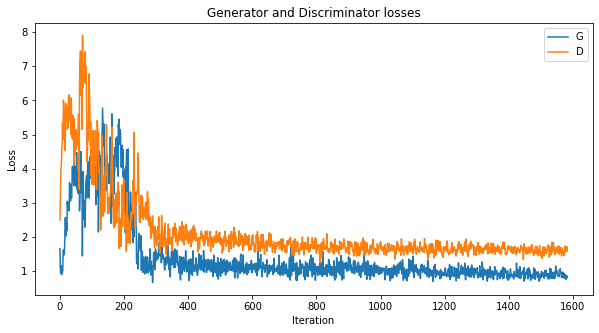

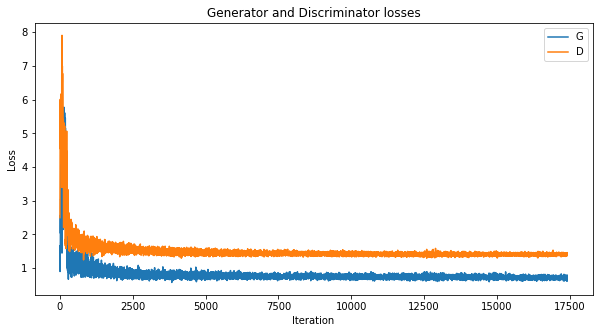

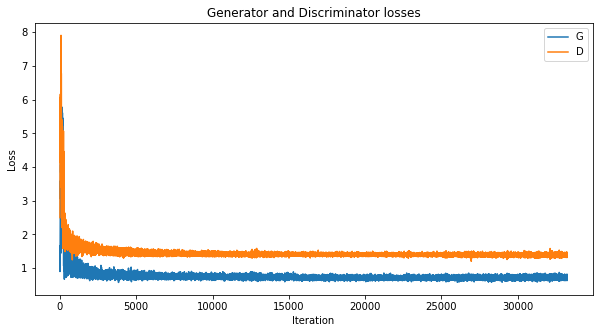

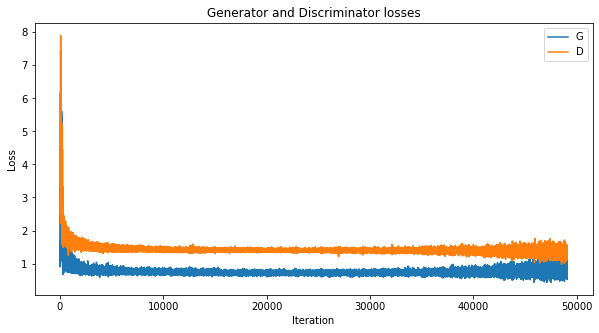

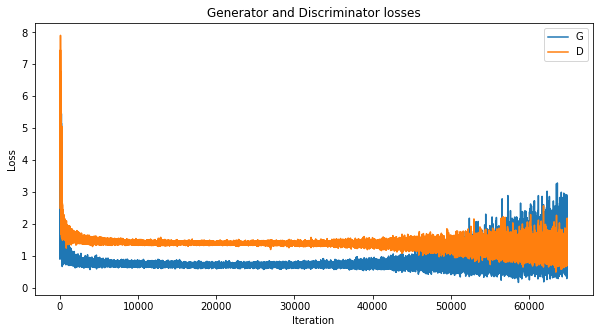

In [19]:
gen_losses = []
disc_losses = []

for epoch in range(epochs):
    start = time.time()
    for i, data in enumerate(data_loader, 0):
        # Train the discriminator
        discriminator.zero_grad()
        
        # Fetch the real data
        real = data[0].to(device)
        size = real.size(0)
        
        # Init labels as ones for real data
        label = torch.full((size,), 1, device=device, dtype=torch.float)
        output = discriminator(real).view(-1)
        
        # Compute loss for real images
        disc_err_real = cross_entropy(output, label)
        disc_err_real.backward()
        real_mean = output.mean().item()
        
        # Train the discriminator on fake images
        noise = torch.randn(size, noise_dim, 1, 1, device=device)
        fake = generator(noise)
        
        # Init labels as zeros for fake data
        label.fill_(0)
        output = discriminator(fake.detach()).view(-1)
        
        # Compute loss for fake images
        disc_err_fake = cross_entropy(output, label)
        disc_err_fake.backward()
        fake_mean = output.mean().item()
        disc_err = disc_err_real + disc_err_fake
        disc_optimizer.step()
        
        # Train the generator
        generator.zero_grad()
        
        # Init labels as ones
        label.fill_(1)
        noise = torch.randn(size, noise_dim, 1, 1, device=device)
        fake = generator(noise)
        output = discriminator(fake).view(-1)
        
        # Compute generator loss
        gen_err = cross_entropy(output, label)
        gen_err.backward()
        gen_mean = output.mean().item()
        gen_optimizer.step()
        
        if i % 100 == 0:
            print('[%d/%d][%d/%d] \tD-Loss:%.4f\t G-Loss:%.4f\t D(x):%.4f\t D(G(z)):%.4f\t G(z):%.4f' 
                  % (epoch + 1, epochs, i + 1, len(data_loader), disc_err.item(), gen_err.item(), real_mean, fake_mean, gen_mean))
            
        gen_losses.append(gen_err.item())
        disc_losses.append(disc_err.item())
        
    end = time.time()
    timedelta = datetime.timedelta(seconds=int(end - start))
    print(f'Time elapsed for epoch {epoch + 1}: {timedelta}\n')
    with torch.no_grad():
        sample = generator(sample_noise).detach().cpu()
    grid = np.transpose(utils.make_grid(sample, padding=4, normalize=True).cpu(), (1, 2, 0))
    
    # Generate samples after every epoch
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(grid)
    plt.savefig(os.path.join(figures_dir, f'epoch_{epoch + 1}.png'))
    plt.close()
    
    if epoch % 10 == 0:
        # Generate loss graph
        plot_loss(gen_losses, disc_losses, epoch + 1, save=True, show=False)
        
        # Save progress
        torch.save(generator, os.path.join(checkpoints_dir, f'generator.pt'))
        torch.save(discriminator, os.path.join(checkpoints_dir, f'discriminator.pt'))

Clear CUDA cache if needed

In [20]:
# torch.cuda.empty_cache()

Plot the loss graph

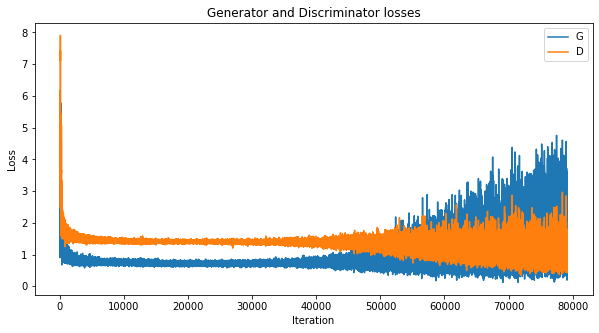

In [23]:
plot_loss(gen_losses, disc_losses, epoch='final', save=True, show=True)

Generate samples on random noise

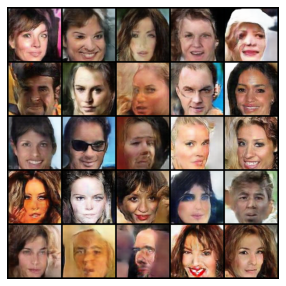

In [22]:
noise = torch.randn(25, noise_dim, 1, 1, device=device).detach()
with torch.no_grad():
    sample = generator(noise).detach().cpu()
grid = np.transpose(utils.make_grid(sample, padding=4, normalize=True, nrow=5).cpu(), (1, 2, 0))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(grid)
# plt.savefig(os.path.join(figures_dir, f'random_{i}.jpg'))
# plt.close()